After traveling through 16 and roughly twice that number of cities in 2013, I wanted to find a way to find similarities between each of the different cities and determine which city I would fit in best.
I had some mental measurement, but the limited amount of time in each city prevents any accurate long term statements about any particular city.
While [facebook](https://facebook.com) or [twitter](https://twitter.com), would probably have provide deeper datasets, the data would require a detailed model of natural language parsing and fake like rejection to beat the noise in each measurement.
So rather than dealing with those hard questions, I decided to dive into the [OkCupid](http://okcupid.com) dataset to try to get some zeroth order results on each question.


OkCupid, gives you the match, friend, and enemy percentages for other members in relation to you.
These percentages are generated by a correlating a large number of questions that you can answer, with your given importance rating for each question.
For this project I will first just focus on the match percentage of females 24-32 as my measure of similarity of each city. 
Originally this measure was used to match census data, but I would like to go back and extend this to including males 24-34, and include a larger age range for both.
To be clear, this will be focused on the following two questions:

* What US cities match me the best?
* Are there significant differences between the population in cities, or is the dominate variable just population?

For some reason I think I should mention that this should not be taken that I should only live in city x because it matches me, nor do I think that one should use this technique to find potential matches.
Honestly by publishing this I think it probably [hurts](http://xkcd.com/833/) my match finding possibilities.
This was merely a exploration of python and and what trends I could see in OkCupid data.

To keep things somewhat clean and fast let me load a bunch of data that I will use below.
(This post was generated by a iPython notebook -- More on that later.)
Most of the heavy lifting is done using requests, and json. 
I would like to rewrite most of the data storage using pandas, but the hacking to beer ratio did not lend itself to more than quick scripts.
The code for this project will be open, and just needs me to clean up one of my libraries.

In [1]:
%matplotlib inline
import pylab
import numpy as np
import pandas as pd
from pprint import pprint
from pycupid import visualize, api, cluster, locations, urban
from pysurvey.plot import setup, line, legend
from pysurvey.util import edit

In [ ]:
locations.LMAP = '/Users/ajmendez/data/okcupid/location_map.json'
ax = visualize.setup_plot()
people = api.loadRandom('random2')
lats, lons = locations.getLatLon(people, update=False)
points = np.array(zip(lons,lats))
shapes = visualize.getShapes()
pops = urban.loadPopulation()
llpolys = visualize.getPolys()
polys = visualize.getPolys(ax.m)
# plot only needed to map polygons
pylab.close()

Originally the plan was to grab census data to [normalize](http://xkcd.com/1138/) out the population differences for each city.
This lead me to learn about the horrible `FIPS` standard, and using the excelent `census` and `us` packages.
In the end, I decided against using this _great_ dataset to limit introducing possible selection biases between the OkCupid population and the highly complete census data.
I mainly realized that OkCupid depends highly on the amount of advertisement it might be doing in each market segment, and the "friend" non-linear effect (a friend gets you to go on it since they are on it).
Nevertheless I will do some quick comparisons between the census data and OkCupid data.

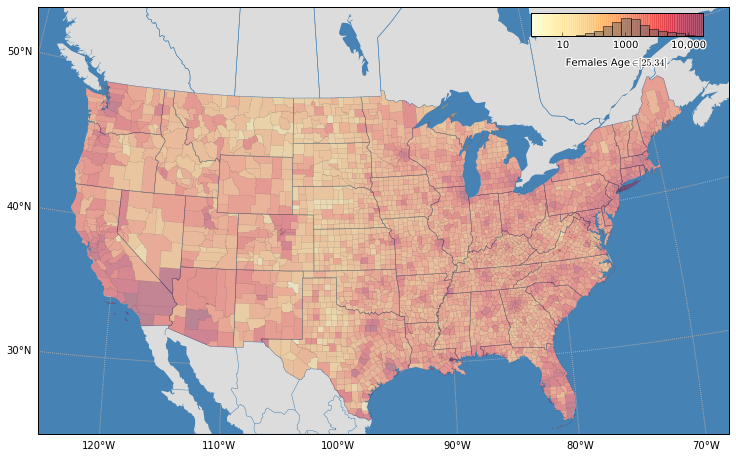

In [65]:
def plot_population():
    '''Plot a comparison sample loaded from US Census data'''
    out = {key:np.log10(pops[key]['female']) for key in pops}
    visualize.plotpoly(polys, out,
                       cmap=pylab.cm.YlOrRd, clim=[0,5.5],
                       clabel='Females Age$\in[25,34]$', 
                       cticks=[1,3,5], 
                       cticknames=['10','1000','10,000'])
    return out
nCensus = plot_population()

Above you may have noticed that I loaded the random data set.
While I call it random, I really doubt that it is really a pseduorandom subsample of the OkCupuid population. 
I think it is really dominated by a mixture of recent logins, and recent signups.
However since I will be taking a ratio of the high matches to the entire sample it should be a fair comparison.

In [66]:
print 'Cities with the five largest samples:'
for p in visualize.toploc(people, n=5, quiet=True):
    print '  {0[0]:20s} {0[1]}'.format(p)

print
print 'Cities with the five highest matches:'
for p in visualize.top(people,'match', n=5, quiet=True):
    print '  {:20s} {}'.format(p['location'], p['match'])

Cities with the five largest samples:
  Chicago, IL          447
  New York, NY         307
  Philadelphia, PA     261
  Los Angeles, CA      254
  Washington, DC       215

Cities with the five highest matches:
  Philadelphia, PA     99
  Arcata, CA           98
  Chicago, IL          97
  Pittsburgh, PA       97
  Palo Alto, CA        97


In [68]:
print ' fips  Census OkC Main City'
for key,logPop in visualize.top(nCensus, n=10, quiet=True):
    ii = visualize.whereShape(points, shapes[key]['shape'])
    print '{0:5s} {1:,} {2[0][1]:3d} {2[0][0]:20s} '.format(key, 
                             int(10**logPop),
                             visualize.toploc([people[i] for i in ii], n=2, quiet=True))

 fips  Census OkC Main City
06037 732,245 254 Los Angeles, CA      
17031 417,627 447 Chicago, IL          
48201 321,556 209 Houston, TX          
04013 270,992  91 Phoenix, AZ          
06073 225,104 110 San Diego, CA        
36047 218,981 183 Brooklyn, NY         
06059 202,770  19 Anaheim, CA          
48113 190,158 114 Dallas, TX           
36061 180,468 307 New York, NY         
36081 180,284  20 Astoria, NY          


So it might not be the best estimator of the underlying population, but lets just see how things are scattered.

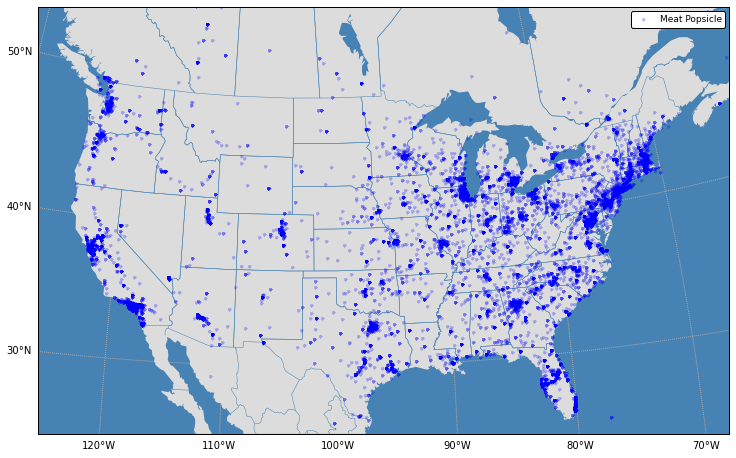

In [70]:
def plot_matches():
    '''Simple scatter plot showing the location of each of the matches.'''
    ax = visualize.setup_plot()
    x,y = ax.m(lons, lats)
    pylab.plot(x,y,'.', alpha=0.25, label='Meat Popsicle')
    legend(loc=1)
plot_matches()

The number per county map generally matches well with the census data, but with a large amount of scatter for low density counties.

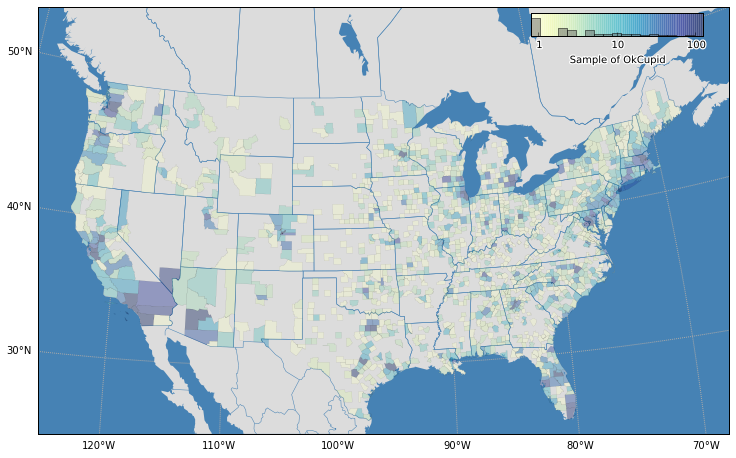

In [71]:
def plot_fips_density():
    '''Group matches by their FIPs location'''
    out = {}
    for key in shapes:
        ii = visualize.whereShape(points, shapes[key]['shape'])
        if len(ii) > 0:
          out[key] = np.log10(len(ii))
    visualize.plotpoly(polys,out, 
                       clim=[-0.1,2.1], 
                       clabel='Sample of OkCupid',
                       cticks=[0,1,2], 
                       cticknames=['1','10','100'])
    return out
nMatch = plot_fips_density()

It is clear from the above figure that there is a large number of really bright counties that do not have very many sampled points.
To limit these counties from dominating the comparison, I will require that there is at least ten samples, and look at the fraction of people above 90%.
Using any match percentage limit above 75-80% gives roughly similar results.

I do not now what is going on with the population spikes at 10% and 20%.
I presume this is the OkCupid servers adding some enemy "spice" to the results.

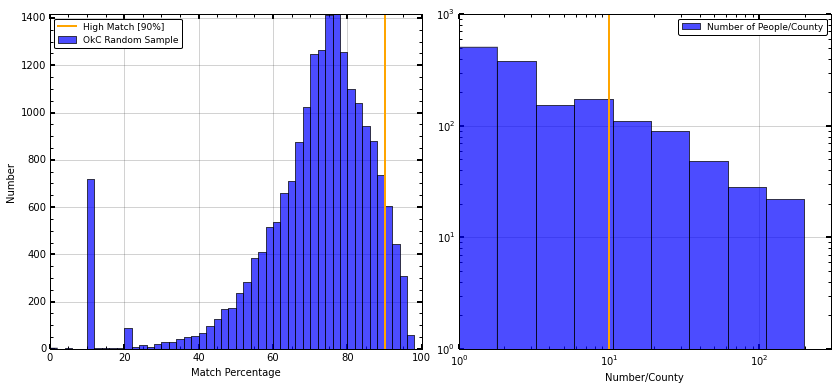

In [72]:
def plot_match_distance():
    x = [p['match'] for p in people]
    setup(figsize=(14,6), subplt=(1,2,1),
          xr=[0,100], xlabel='Match Percentage', ylabel='Number')
    xbin = np.arange(0,100,2)
    pylab.hist(x, xbin, alpha=0.7, label='OkC Random Sample')
    mx = 90
    line(x=mx, label='High Match [{:0.0f}%]'.format(mx))
    legend(loc=2)
    
    setup(subplt=(1,2,2), 
          xr=[1,300], xlog=True, xlabel='Number/County', 
          yr=[1,1000], ylog=True)
    pylab.hist([10.0**x for x in nMatch.values()], 
               np.logspace(0,2.3,10), alpha=0.7, 
               label='Number of People/County')
    legend(loc=1)
    line(x=10)
    
plot_match_distance()

One interesting bit that we can find from the data is the roughly linear number of sampled individuals in each county to the census population estimates.
This suggests that there is not a dominate non-linear population friend effect (you get on OkCupid if your friends are on it).


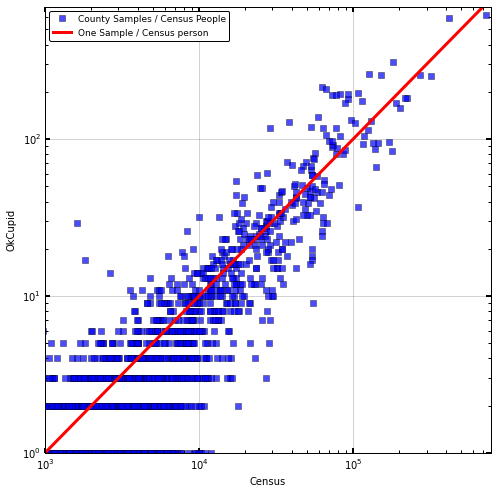

In [75]:
def plot_fips_size():
    x = [10.0**nCensus[k] for k in nMatch]
    y = [10.0**nMatch[k] for k in nMatch]
    setup(figsize=(8,8),
          xr=[1e3,7.9e5], xlog=True, xlabel='Census',
          yr=[1.0,700], ylog=True, ylabel='OkCupid',
          )
    pylab.plot(x,y,'s', lw=0, alpha=0.7,
               label='County Samples / Census People')
    pylab.plot([1e3,1e6],[1,1e3],'r', lw=3, 
               label='One Sample / Census person')
    legend(loc=2)

plot_fips_size()

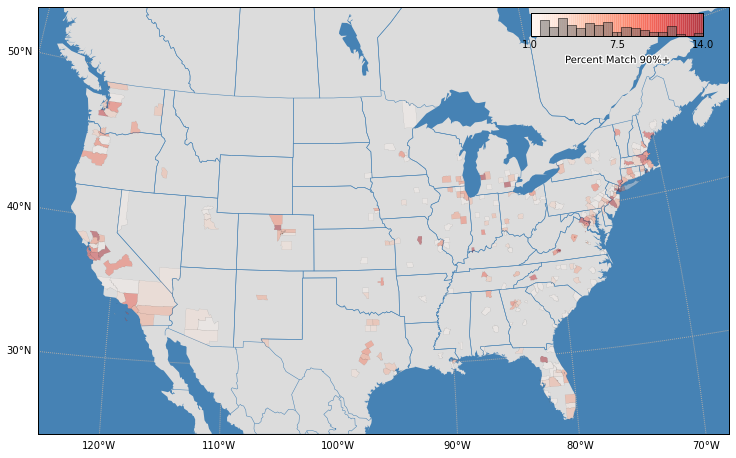

In [77]:
def plot_fraction(matchlim=90):
    matches = np.array([p['match'] for p in people])
    out,extra = {},{}
    for key in shapes:
        ii = visualize.whereShape(points, shapes[key]['shape'])
        if len(ii) > 10:
            jj = np.where(matches[ii] > matchlim)[0]
            out[key] = len(jj)/float(len(ii))*100.0
            cities = visualize.toploc([people[i] for i in ii], 
                                      n=3, quiet=True)
            extra[key] = dict(percent=out[key],
                              match = matches[ii],
                              number = len(ii), 
                              numberhigh = len(jj),
                              cities=cities)
    visualize.plotpoly(polys, out, 
                       cmap=visualize.reds, clim=[1,14],
                       clabel='Percent Match 90%+')
    return extra
        
nFraction = plot_fraction()

In [78]:
tmp = [nf for nf in nFraction.values() if nf['number'] > 40]
print 'Num   Percent   Three Largest Citites'
for t in visualize.top(tmp, 'percent', n=20, quiet=True):
    cities = ', '.join([c[0] for c in t['cities']])
    print u'{0:3.0f} {1:8.1f}    {2}'.format(t['number'], 
                                             t['percent'], 
                                             cities)

Num   Percent   Three Largest Citites
194     22.7    San Francisco, CA
 42     16.7    Newark, DE, Newark, NJ, Montclair, NJ
 59     15.3    Ann Arbor, MI, Ypsilanti, MI, Belleville, MI
215     14.9    Washington, DC
310     13.9    New York, NY, Columbia City, IN, New City, NY
 45     13.3    San Mateo, CA, Redwood City, CA, Daly City, CA
198     12.6    Cambridge, MA, Somerville, MA, Lowell, MA
131     12.2    San Jose, CA, Palo Alto, CA, Sunnyvale, CA
183     11.5    Brooklyn, NY
 80     11.2    Fairfax, VA, Herndon, VA, Springfield, VA
190     11.1    Boston, MA, Brighton, MA, Dorchester, MA
 68     10.3    Brookline, MA, Quincy, MA, Braintree, MA
620     10.0    Los Angeles, CA, Long Beach, CA, Pasadena, CA
 61      9.8    Arlington, VA
 82      9.8    Nashville, TN, Antioch, TN, Hermitage, TN
257      9.7    Seattle, WA, Renton, WA, Kent, WA
175      9.7    Oakland, CA, Berkeley, CA, Fremont, CA
261      9.6    Philadelphia, PA
107      9.3    Silver Spring, MD, Bethesda, MD, Ro

Number of estimated clusters : 224


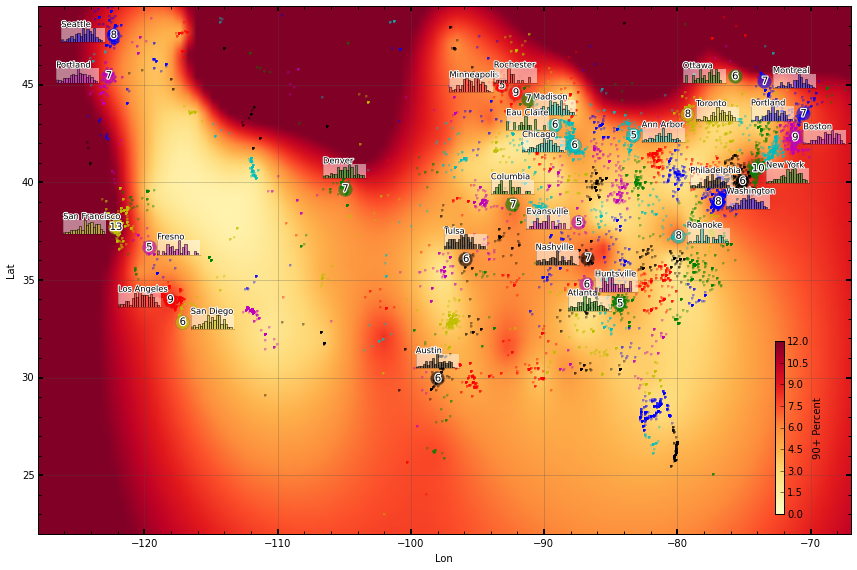

In [80]:
#jekyll.hide
def plot_field_cluster():
    '''Use meanshift to determine the overal clustering of different areas'''
    peo,lat,lon = cluster.getUS(people, lats, lons)
    X, labels, centers = cluster.find(peo, lat, lon, 
                                      quantile=0.01, 
                                      nsamples=100000)
    cluster.simpleplot(peo, X, labels, centers)
    return peo,X,labels,centers

peo,X,labels,centers = plot_field_cluster()

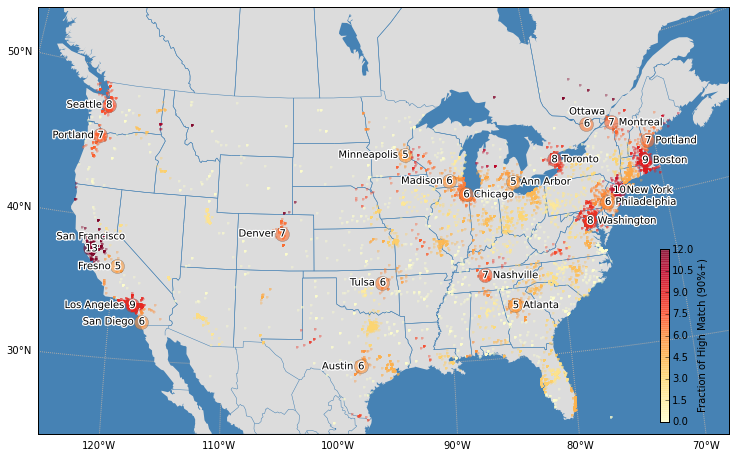

In [81]:
def plot_cluster_map():
    visualize.setup_plot()
    nC = cluster.plot(peo, X, labels, centers, nlimit=40,
                      addhist=False, addcity=True, 
                      label='Fraction of High Match (90%+)',
                      cmap=pylab.cm.YlOrRd, crange=[0,12])
    return nC

nCluster = plot_cluster_map()

In [82]:
print '  Percent  Num   Top Three Largest Metropolitan Areas'
for n in nCluster:
    if n[0] > 7:
        print(u'{0[0]:8.2f}  {0[1]:4d}   {0[2]}'.format(n))

  Percent  Num   Top Three Largest Metropolitan Areas
   12.57   907   San Francisco, CA, Sacramento, CA, San Jose, CA
    9.97   953   New York, NY, Brooklyn, NY, Bronx, NY
    9.04   752   Boston, MA, Cambridge, MA, Somerville, MA
    8.58   944   Los Angeles, CA, Long Beach, CA, Riverside, CA
    8.31  1083   Washington, DC, Baltimore, MD, Arlington, VA
    8.13   283   Toronto, Ontario, CA, Buffalo, NY, Niagara Falls, NY
    7.54   451   Seattle, WA, Tacoma, WA, Renton, WA
    7.14   140   Nashville, TN, Murfreesboro, TN, Clarksville, TN
    7.06   411   Portland, OR, Beaverton, OR, Salem, OR


### Differences in Cities

Using the match percentage distributions we can see how different each city population is from the others.

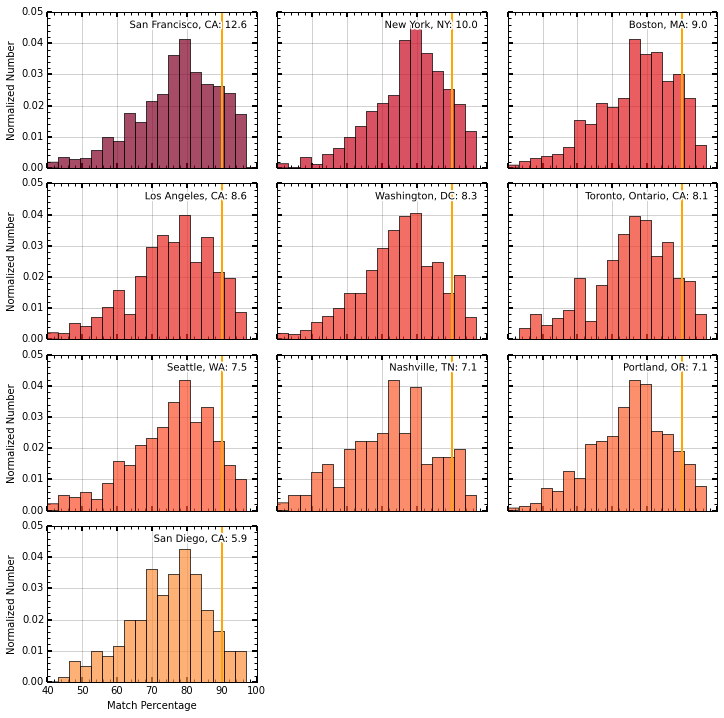

In [83]:
dist = cluster.plotdist(peo, labels, 
                        cmap=pylab.cm.YlOrRd,
                        crange=[0,12])

Calculate the KS two sample statistic to see how probable the differences are.

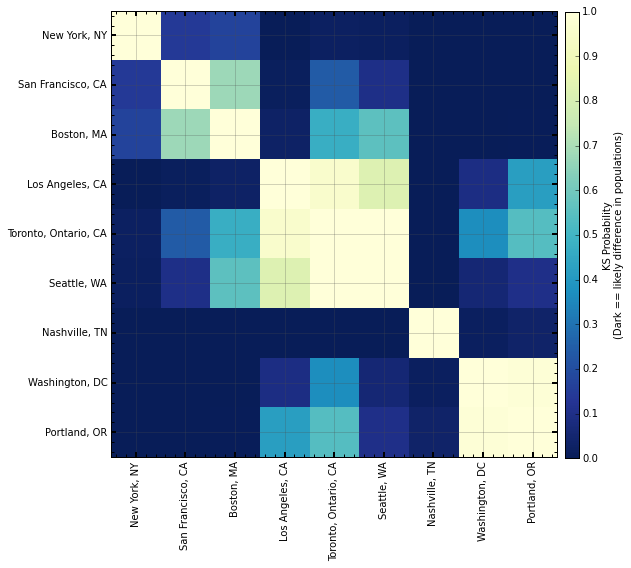

In [85]:
cluster.compare_cities(
    dist,
                       label='KS Probability\n'+
                       '(Dark == likely difference in populations)')